<a href="https://colab.research.google.com/github/yassine-cherni/NLP/blob/main/CNN_MODEL20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install -U -q tensorflow tensorflow_datasets
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
DATASET_PATH = '/content/drive/MyDrive/DATA/AUDIO'

data_dir = pathlib.Path(DATASET_PATH)
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 90.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 76.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 94.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 71.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 37.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.16.1 which is incompatible.
Commands: ['LIGHT_ON' 'DISABLE_LANE_ASSIST' 'TURN_Off_VENTILATION'
 'TURN_ON_VENTILATION' 'POWER_ON_FOCUS' 'POWER_OFF_FOCUS'
 'ACTIVATE_LANE_ASSIST' 'LIGHT_OFF' '.ipynb_checkpoints']


In [4]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)
train_ds.element_spec
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)
label_names[[1,1,3,0]]

Found 8014 files belonging to 8 classes.
Using 6412 files for training.
Using 1602 files for validation.

label names: ['ACTIVATE_LANE_ASSIST' 'DISABLE_LANE_ASSIST' 'LIGHT_OFF' 'LIGHT_ON'
 'POWER_OFF_FOCUS' 'POWER_ON_FOCUS' 'TURN_ON_VENTILATION'
 'TURN_Off_VENTILATION']
(64, 16000)
(64,)


array(['DISABLE_LANE_ASSIST', 'DISABLE_LANE_ASSIST', 'LIGHT_ON',
       'ACTIVATE_LANE_ASSIST'], dtype='<U20')

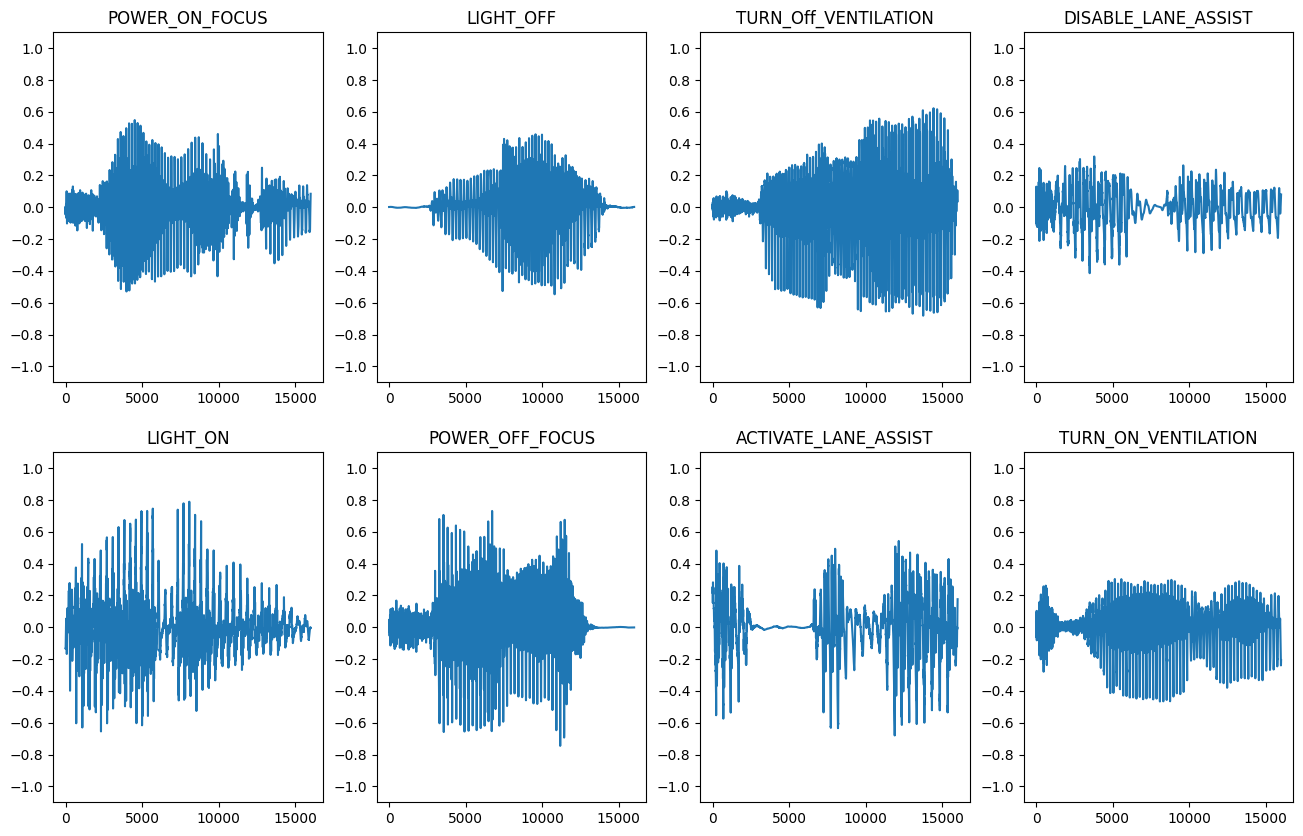

In [12]:
import random

# ... (Previous code)

plt.figure(figsize=(16, 10))
rows = 2
cols = 4  # Plot 8 commands
n = rows * cols

# Get 8 unique commands (without repetition)
unique_commands = random.sample(list(label_names), n)

# Iterate through the unique commands and find the corresponding audio
for i, command in enumerate(unique_commands):
  plt.subplot(rows, cols, i+1)
  # Find the index of the command in the label_names array
  command_index = np.where(label_names == command)[0][0]

  # Find the first occurrence of this command in the example_labels batch
  audio_index = np.where(example_labels == command_index)[0][0]
  audio_signal = example_audio[audio_index]

  plt.plot(audio_signal)
  plt.title(command)
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [13]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: LIGHT_ON
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: ACTIVATE_LANE_ASSIST
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: POWER_ON_FOCUS
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


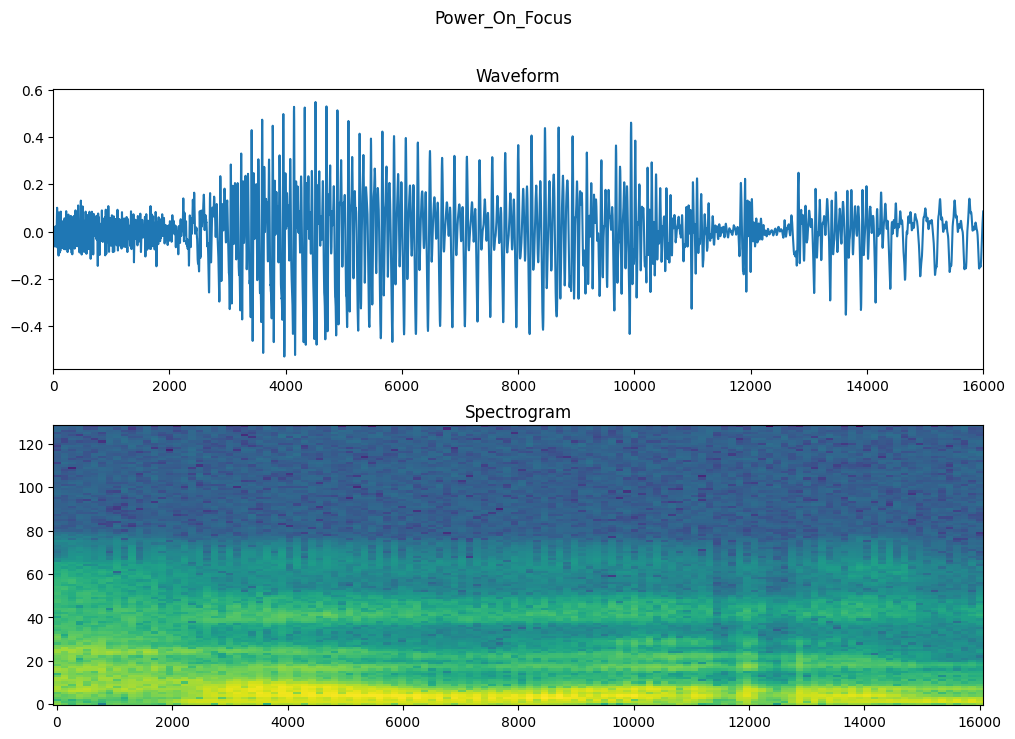

In [14]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

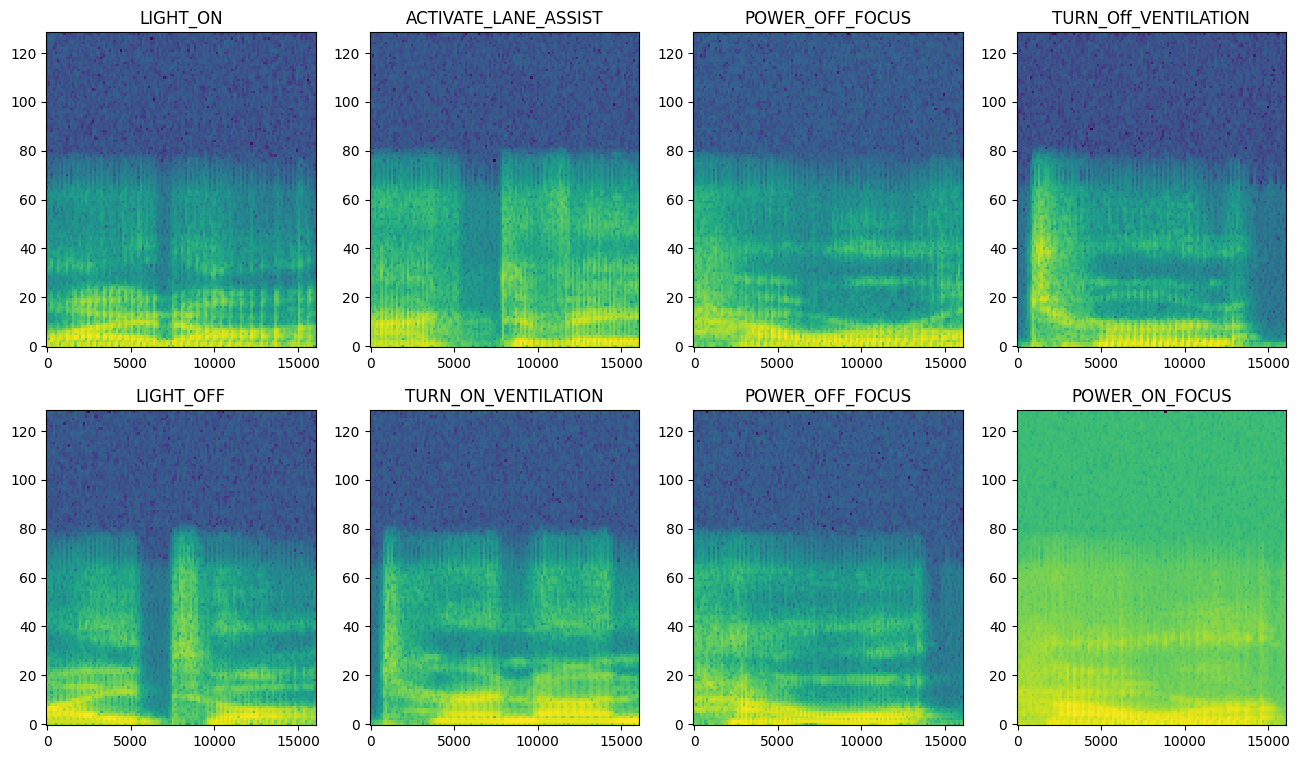

In [15]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break
rows = 2  # Plot 8 commands
cols = 4
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

Input shape: (124, 129, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,625,611 (6.20 MB)

 Trainable params: 1,625,608 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

Epoch 1/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 374s 4s/step - accuracy: 0.5176 - loss: 1.2385 - val_accuracy: 0.7078 - val_loss: 0.5331
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7195 - loss: 0.5729 - val_accuracy: 0.8091 - val_loss: 0.4097
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7700 - loss: 0.4729 - val_accuracy: 0.8519 - val_loss: 0.3597
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7932 - loss: 0.4162 - val_accuracy: 0.8610 - val_loss: 0.3176
Epoch 5/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8149 - loss: 0.3858 - val_accuracy: 0.8117 - val_loss: 0.3421
Epoch 6/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8282 - loss: 0.3521 - val_accuracy: 0.8740 - val_loss: 0.3007
Epoch 7/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8410 - loss: 0.3291 - val_accuracy: 0.8766 - val_loss: 0.2882
Epoch 8/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8396 - loss: 0.3352 - val_accuracy: 0

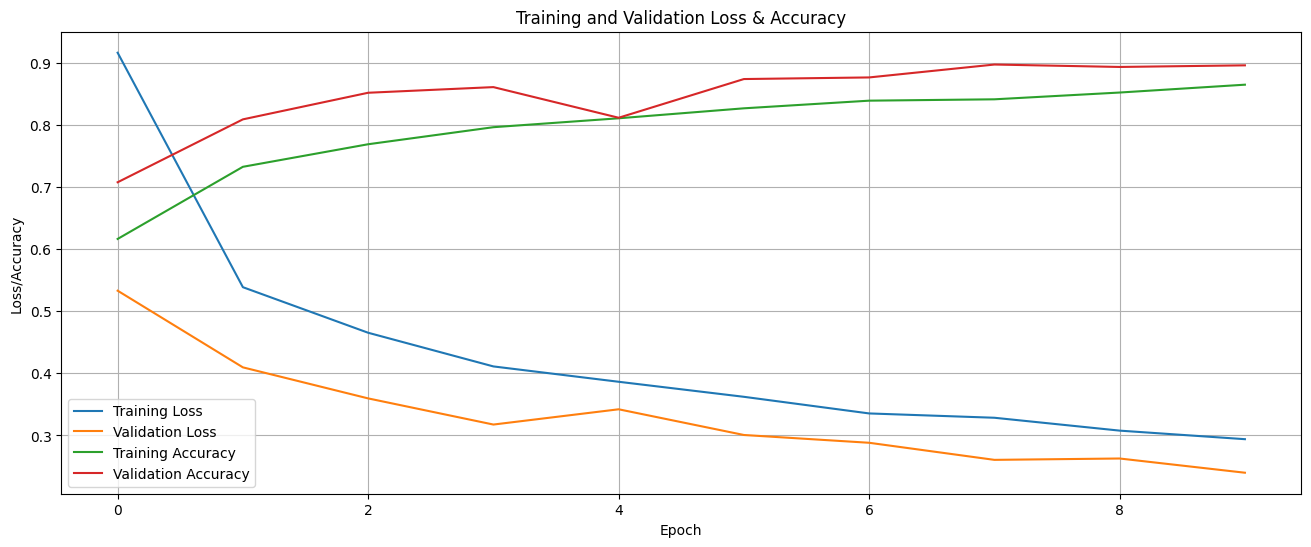

In [16]:
# ... (Previous code)

train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)
metrics = history.history

plt.figure(figsize=(16, 6))  # Adjusted figure size

# Plot loss and validation loss
plt.plot(history.epoch, metrics['loss'], label='Training Loss')
plt.plot(history.epoch, metrics['val_loss'], label='Validation Loss')

# Plot accuracy and validation accuracy
plt.plot(history.epoch, metrics['accuracy'], label='Training Accuracy')
plt.plot(history.epoch, metrics['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.title('Training and Validation Loss & Accuracy')
plt.grid(True)
plt.show()